In [1]:
#!/usr/bin/env python3

# author: Michael A. Perlin (github.com/perlinm)

import itertools, numpy, qiskit
import circuit_cutter
import mlrecon_methods as ml

import numpy as np
import qiskit
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile

from qiskit.transpiler import PassManager

from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer, plot_histogram
from qiskit.compiler import assemble
from qiskit.tools.monitor import job_monitor

# The pulse simulator
from qiskit.providers.aer import PulseSimulator

from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview

import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel

from utils.utils import filter_results, dict_to_list, H_distance, total_counts

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}

In [3]:
numpy.set_printoptions(linewidth = 200)

qubits = 5

# # should be "GHZ", "cascade", "dense", or "clustered"
# circuit_type = "GHZ"
# layers = 1 # number of gate layers

# qubits = 6 # number of qubits
# frag_num = 2 # number of fragments

simulation_backend = "qasm_simulator"

seed = 0
print_circuits = True

In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='chm185')
provider.backends()

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_montreal') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-ornl', grou

In [5]:
device = provider.get_backend('ibmq_guadalupe')
device

<IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>

In [6]:
noisy_simulator = provider.get_backend('ibmq_qasm_simulator')

In [7]:
front_layer = QuantumCircuit.from_qasm_file("qasm/vqe_5q_front.qasm")

In [8]:
mid_layer = QuantumCircuit.from_qasm_file("qasm/vqe_5q_mid.qasm")

In [9]:
end_layer = QuantumCircuit.from_qasm_file("qasm/vqe_5q_end.qasm")

In [10]:
orign_circuit = front_layer + mid_layer + end_layer

In [11]:
#checking circuit

In [12]:
def apply_checking_circuit(qc, ctrl_bits, ancilla_bits, side = None):
    if len(ctrl_bits) != len(ancilla_bits):
        print("Size mismatch")
        return None
    if side == 'front':
        for i in ancilla_bits:
            qc.h(i)
        for j,k in zip(ctrl_bits, ancilla_bits):
            qc.cz(j, k)
    elif side == 'end':
        for j,k in zip(ctrl_bits, ancilla_bits):
            qc.cz(j, k)
        for i in ancilla_bits:
            qc.h(i)
    else:
        print("Side undefined")

In [70]:
circuit = front_layer.copy()

In [73]:
circuit.barrier()
apply_checking_circuit(circuit, [3], [5], side = 'front')
circuit += mid_layer
apply_checking_circuit(circuit, [3], [5], side = 'end')
circuit.barrier()
circuit += end_layer
circuit.barrier()
apply_checking_circuit(circuit, [3], [5], side = 'front')
circuit += mid_layer
apply_checking_circuit(circuit, [3], [5], side = 'end')
circuit.barrier()
circuit += end_layer

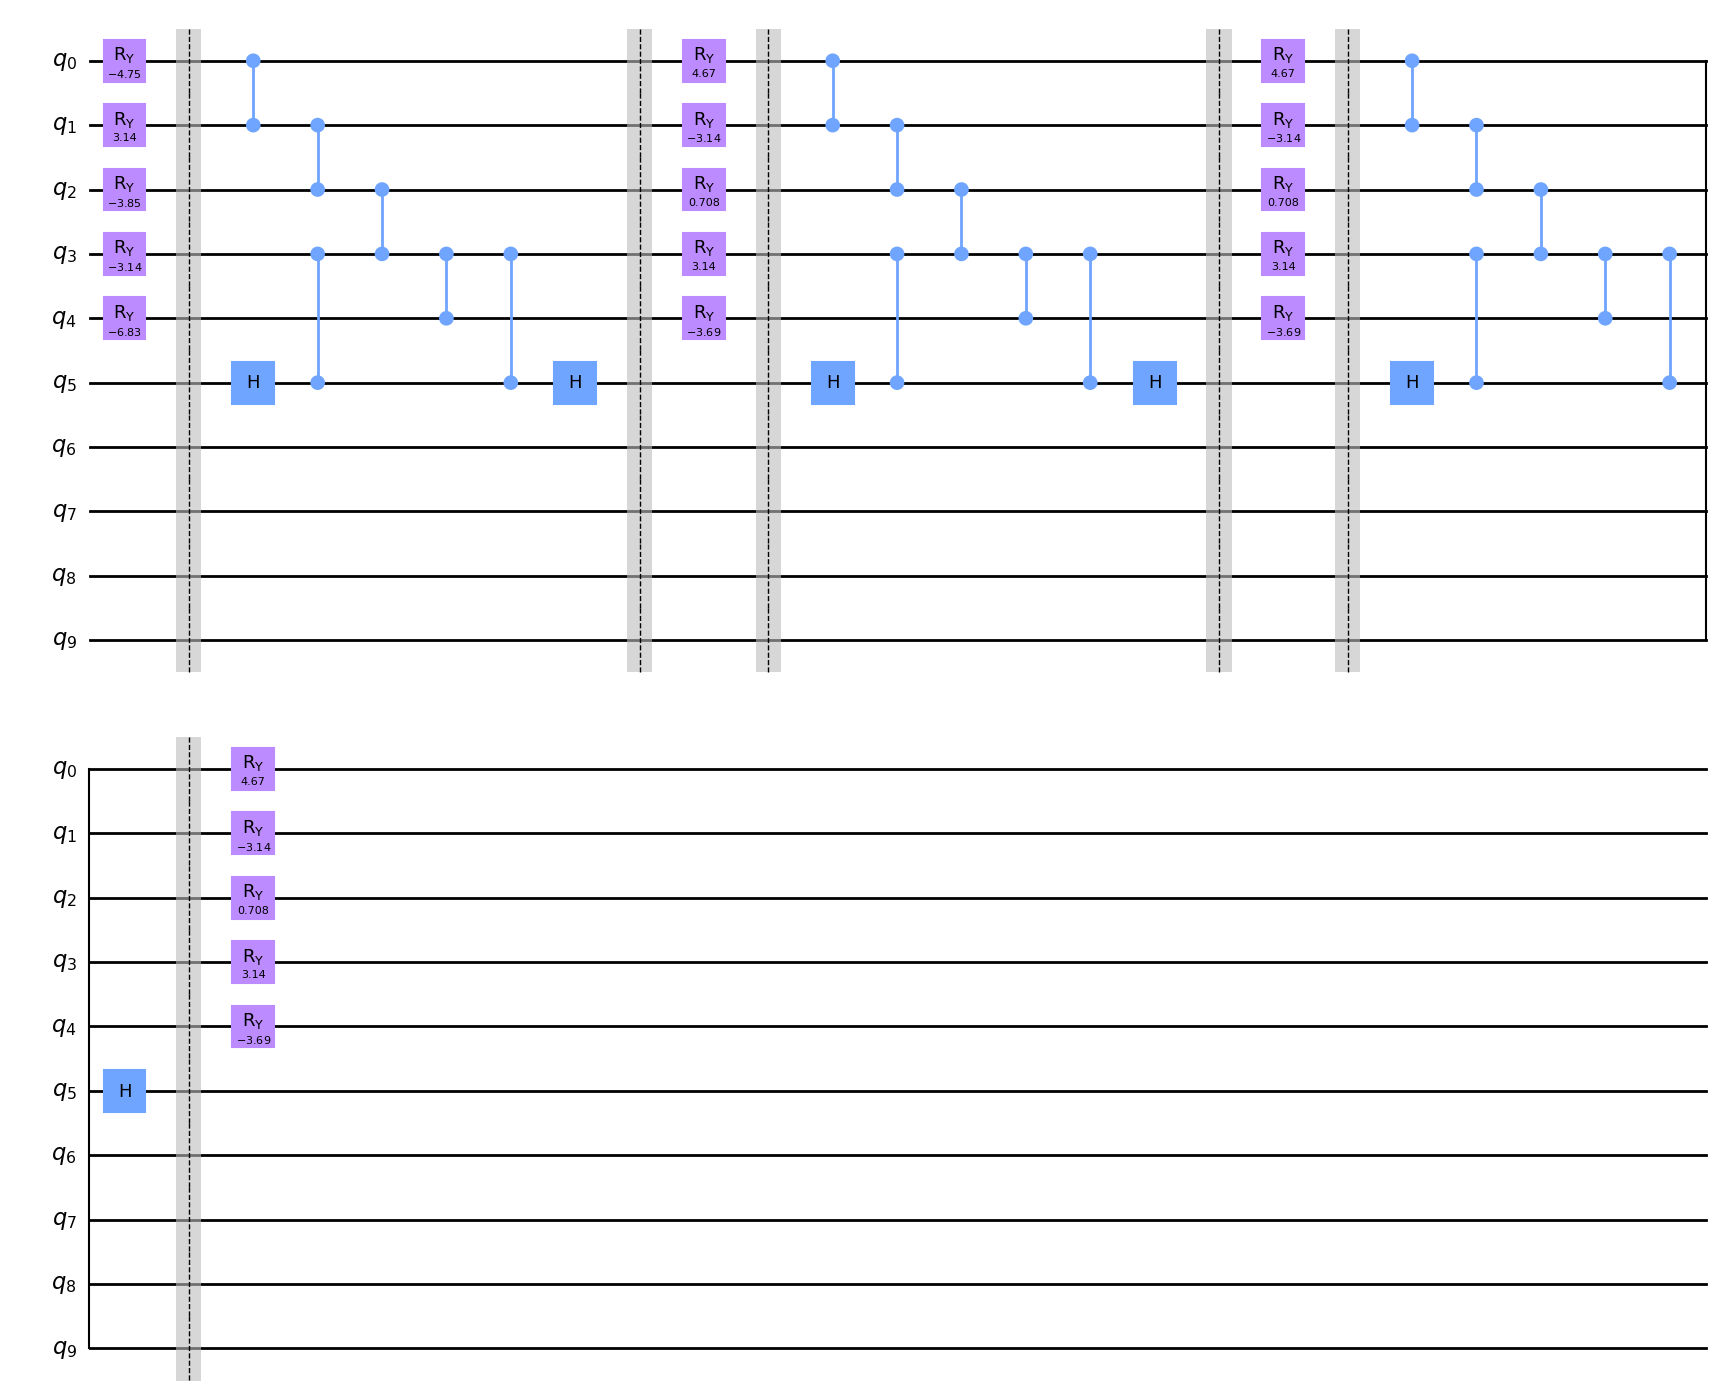

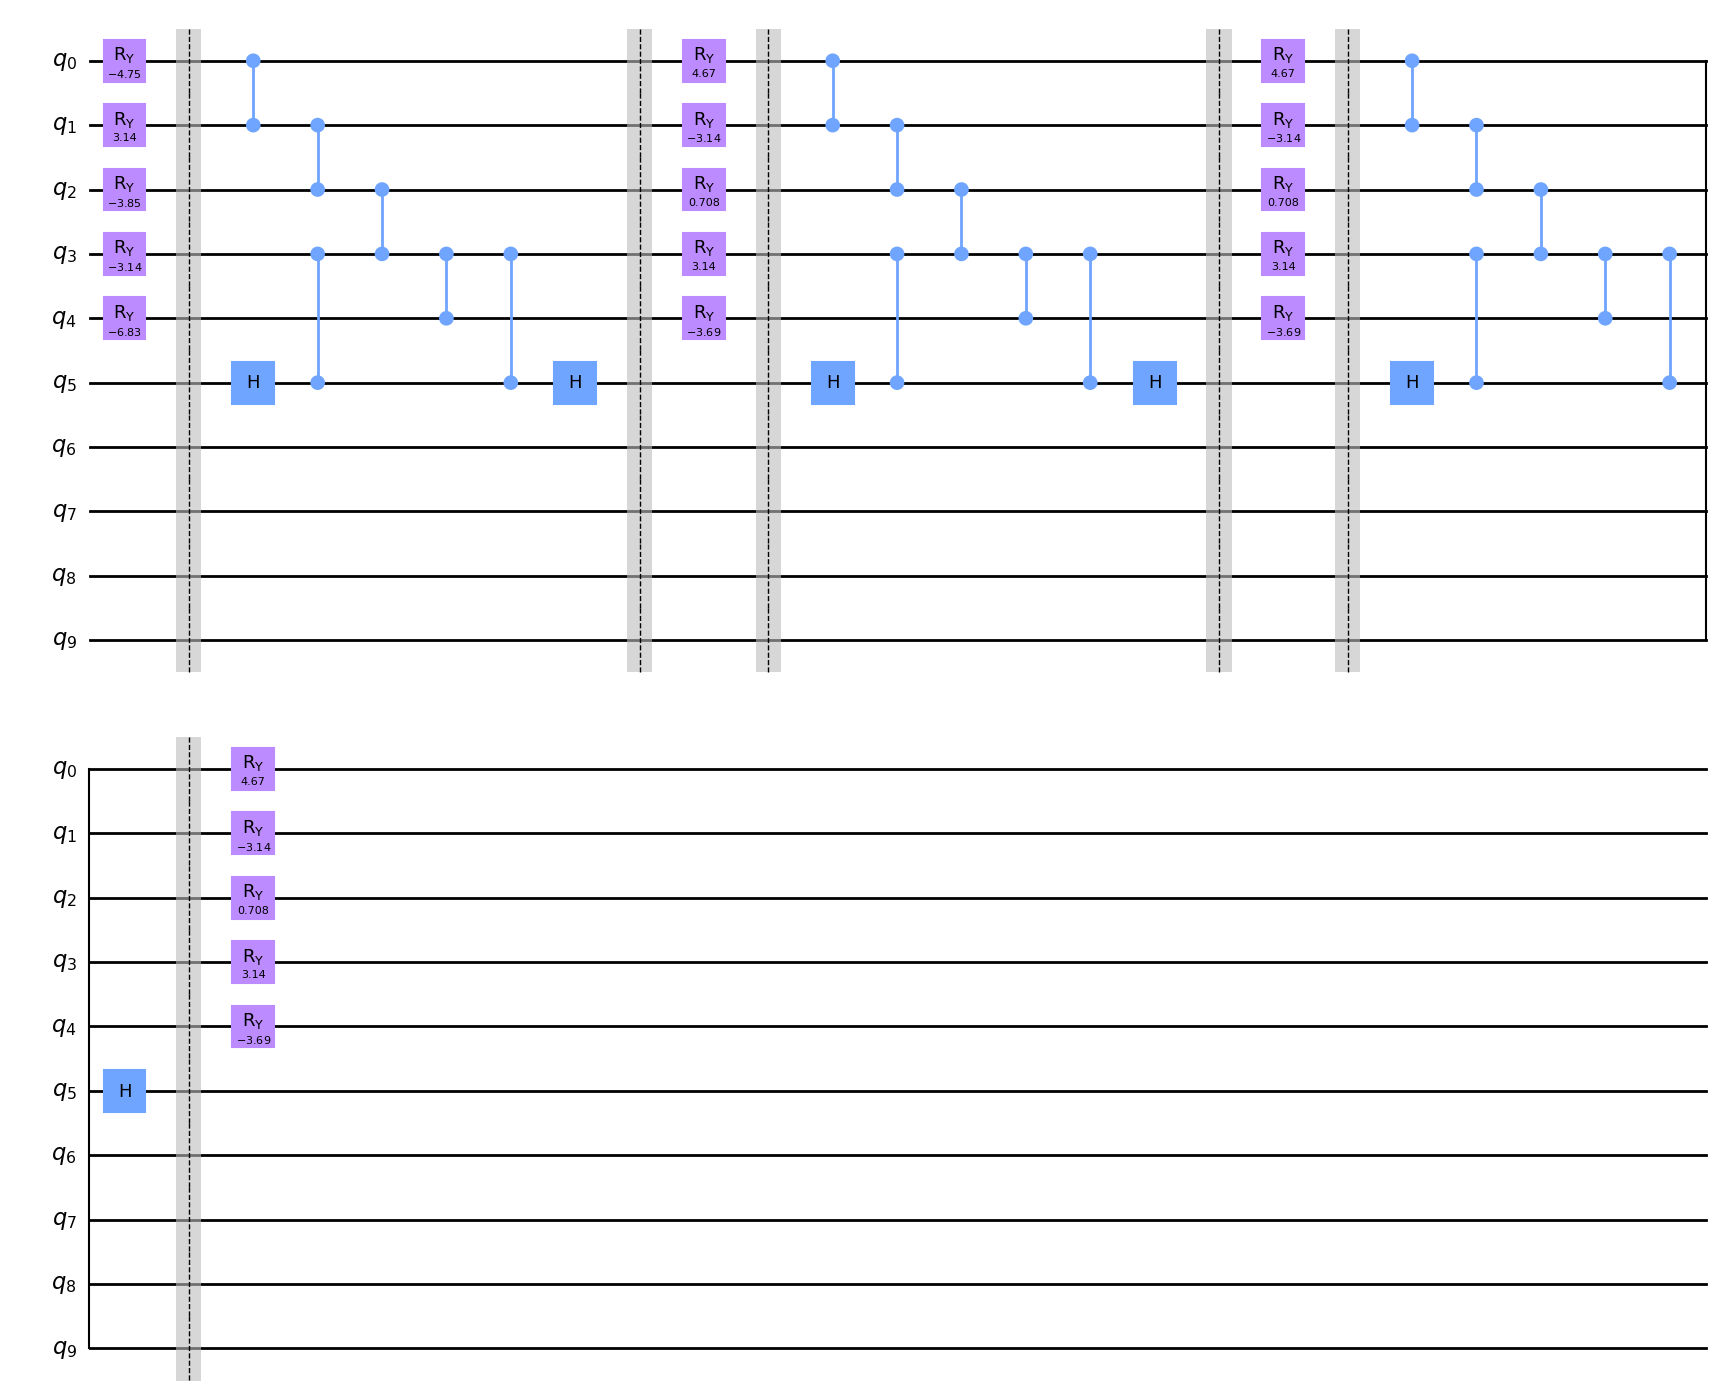

In [74]:
circuit.draw(output = 'mpl')

In [16]:
trans_qc = transpile(circuit, basis_gates = ['sx', 'cx', 'reset', 'id', 'x', 'rz'])

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/circuit/tools/pi_check.py:49: SymPyDeprecationWarning: 

The expr_free_symbols property is deprecated. Use free_symbols to get
the free symbols of an expression.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-expr-free-symbols
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  syms = inpt._symbol_expr.expr_free_symbols


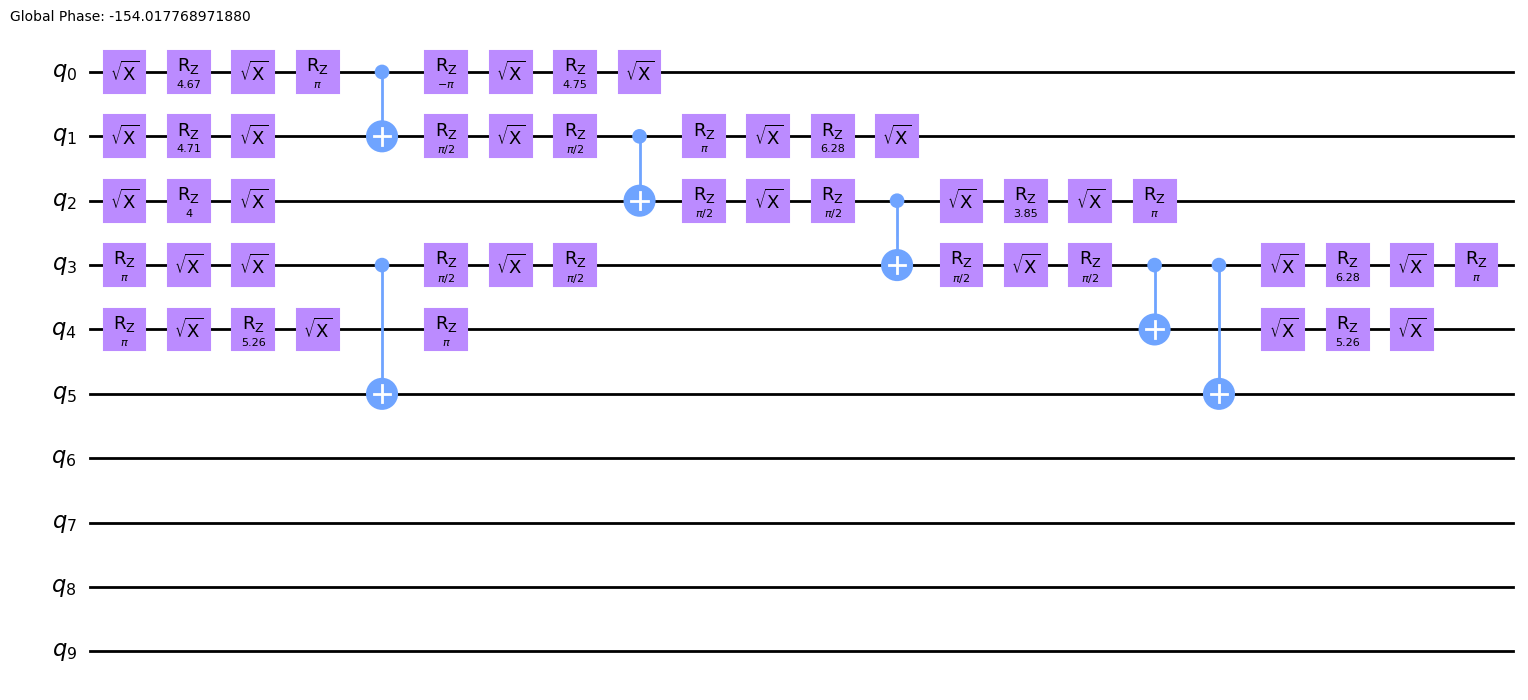

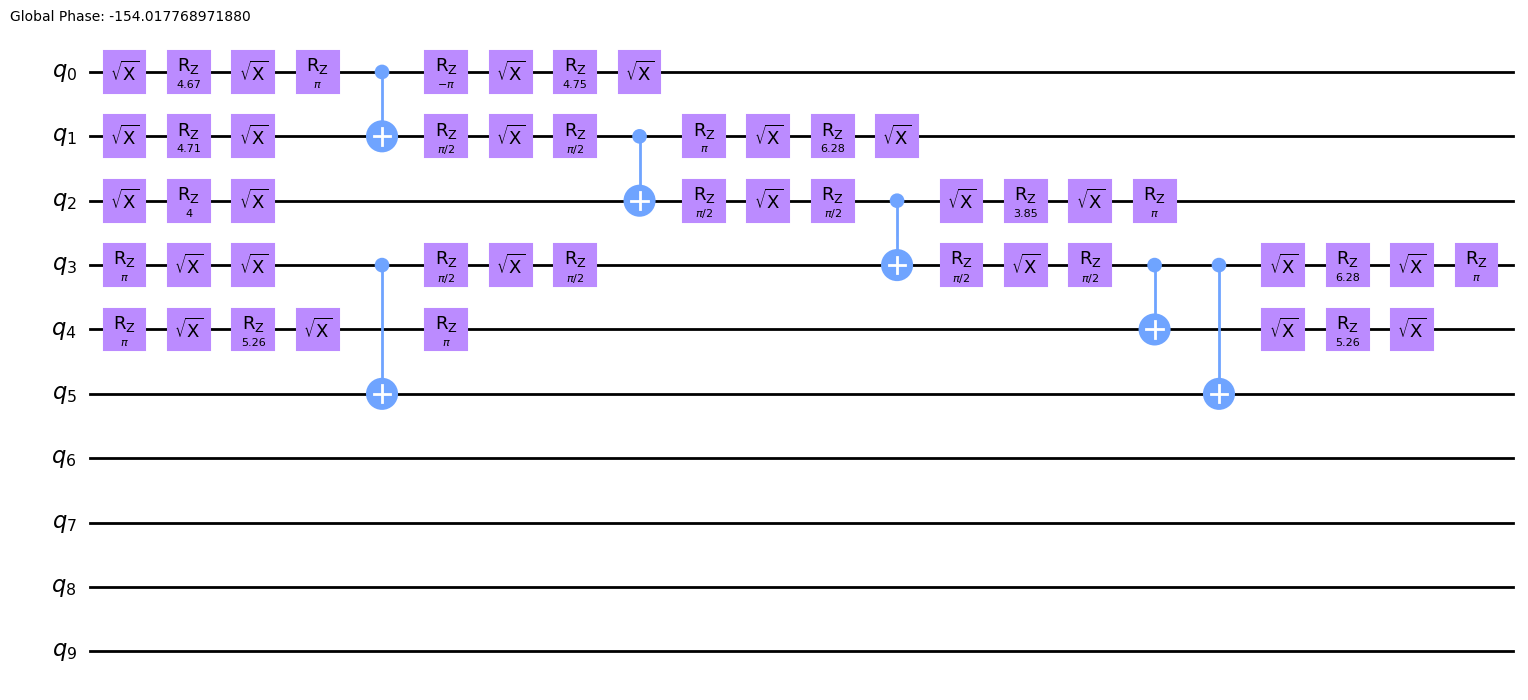

In [17]:
trans_qc.draw(output = 'mpl')

In [18]:
from qiskit import IBMQ, Aer
from qiskit.providers.aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(device, gate_error = False, thermal_relaxation= False)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u3']
  Instructions with noise: ['measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  Specific qubit errors: [('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4]), ('measure', [5]), ('measure', [6]), ('measure', [7]), ('measure', [8]), ('measure', [9]), ('measure', [10]), ('measure', [11]), ('measure', [12]), ('measure', [13]), ('measure', [14]), ('measure', [15])]


In [19]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [20]:
# p_gate1 = 0.4
# error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
# error_gate2 = error_gate1.tensor(error_gate1)

In [21]:
# noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])

In [22]:
circuit = trans_qc

In [23]:
cuts = []
# for i in range(0, 5):
#     if i == 0:
#         cut = [(circuit.qubits[i], 5),(circuit.qubits[i], 6)]
#     elif i == 3:
#         cut = [(circuit.qubits[i], 4),(circuit.qubits[i], 12)]
#     elif i == qubits-1:
#         cut = [(circuit.qubits[i], 5),(circuit.qubits[i], 12)]
#     else:
#         cut = [(circuit.qubits[i], 5),(circuit.qubits[i], 13)]
#     cuts += cut
cuts = [(circuit.qubits[3], 4),(circuit.qubits[3], 12)]

In [24]:
print(cuts)

[(Qubit(QuantumRegister(10, 'q'), 3), 4), (Qubit(QuantumRegister(10, 'q'), 3), 12)]


In [25]:
fragments, wire_path_map = circuit_cutter.cut_circuit(circuit, cuts)

unused qubits: [Qubit(QuantumRegister(10, 'q'), 6), Qubit(QuantumRegister(10, 'q'), 7), Qubit(QuantumRegister(10, 'q'), 8), Qubit(QuantumRegister(10, 'q'), 9)]


In [26]:
print(wire_path_map)

{Qubit(QuantumRegister(10, 'q'), 0): ((0, Qubit(QuantumRegister(5, 'q'), 4)),), Qubit(QuantumRegister(10, 'q'), 1): ((0, Qubit(QuantumRegister(5, 'q'), 2)),), Qubit(QuantumRegister(10, 'q'), 2): ((0, Qubit(QuantumRegister(5, 'q'), 0)),), Qubit(QuantumRegister(10, 'q'), 3): ((1, Qubit(QuantumRegister(3, 'q'), 0)), (0, Qubit(QuantumRegister(5, 'q'), 1)), (1, Qubit(QuantumRegister(3, 'q'), 2))), Qubit(QuantumRegister(10, 'q'), 4): ((0, Qubit(QuantumRegister(5, 'q'), 3)),), Qubit(QuantumRegister(10, 'q'), 5): ((1, Qubit(QuantumRegister(3, 'q'), 1)),), Qubit(QuantumRegister(10, 'q'), 6): ((2, Qubit(QuantumRegister(4, 'q'), 0)),), Qubit(QuantumRegister(10, 'q'), 7): ((2, Qubit(QuantumRegister(4, 'q'), 1)),), Qubit(QuantumRegister(10, 'q'), 8): ((2, Qubit(QuantumRegister(4, 'q'), 2)),), Qubit(QuantumRegister(10, 'q'), 9): ((2, Qubit(QuantumRegister(4, 'q'), 3)),)}


In [27]:
total_variants = ml.fragment_variants(wire_path_map)

In [28]:
total_variants

25

In [29]:
shots = 32000 * total_variants

In [30]:
if print_circuits:
    print("total circuit:")
    print(circuit)
    print("cuts:")
    for cut in cuts:
        print("",cut)
    print()
    for idx, fragment in enumerate(fragments):
        print(f"fragment {idx}:")
        print(fragment)
        print()
    fragment_cuts = ml.fragment_cuts(wire_path_map)
    print("fragment_index, prep_cuts, meas_cuts:")
    for frag_idx, frag_cuts in enumerate(fragment_cuts):
        print(frag_idx, frag_cuts["prep"], frag_cuts["meas"])
    print()
    print("total number of fragment variants:", total_variants)
    print("total number of shots:", ( shots // total_variants ) * total_variants)
    print()

total circuit:
global phase: -154.017768971880
       ┌────┐ ┌────────────┐    ┌────┐    ┌───────┐      ┌────────┐┌────┐»
q_0: ──┤ √X ├─┤ RZ(4.6738) ├────┤ √X ├────┤ RZ(π) ├──■───┤ RZ(-π) ├┤ √X ├»
       ├────┤ ├────────────┤    ├────┤    └───────┘┌─┴─┐┌┴────────┤├────┤»
q_1: ──┤ √X ├─┤ RZ(4.7123) ├────┤ √X ├─────────────┤ X ├┤ RZ(π/2) ├┤ √X ├»
       ├────┤ ├────────────┤    ├────┤             └───┘└─────────┘└────┘»
q_2: ──┤ √X ├─┤ RZ(4.0048) ├────┤ √X ├───────────────────────────────────»
     ┌─┴────┴┐└───┬────┬───┘    ├────┤                  ┌─────────┐┌────┐»
q_3: ┤ RZ(π) ├────┤ √X ├────────┤ √X ├───────────────■──┤ RZ(π/2) ├┤ √X ├»
     ├───────┤    ├────┤    ┌───┴────┴───┐  ┌────┐   │  └┬───────┬┘└────┘»
q_4: ┤ RZ(π) ├────┤ √X ├────┤ RZ(5.2627) ├──┤ √X ├───┼───┤ RZ(π) ├───────»
     └───────┘    └────┘    └────────────┘  └────┘ ┌─┴─┐ └───────┘       »
q_5: ──────────────────────────────────────────────┤ X ├─────────────────»
                                                   └─

In [31]:
print(fragment_cuts)

[{'prep': 1, 'meas': 1}, {'prep': 1, 'meas': 1}, {'prep': 0, 'meas': 0}]


In [32]:
# list of all possible measurement outcomes (bitstrings)
all_bits = [ "".join(bits) for bits in itertools.product(["0","1"], repeat = qubits) ]

In [33]:
print(all_bits)

['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


In [34]:
# # get the actual state / probability distribution for the full circuit
# actual_state = ml.get_statevector(circuit)
# actual_dist = { "".join(bits) : abs(amp)**2
#                 for bits, amp in zip(all_bits, actual_state)
#                 if amp != 0 }

# # get a simulated probability distribution for the full circuit
# circuit.measure_active()
# full_circuit_result = ml.run_circuits(circuit, shots, backend = simulation_backend)
# full_circuit_dist = {}
# for part in full_circuit_result:
#     for bits, counts in part.get_counts(circuit).items():
#         if bits not in full_circuit_dist:
#             full_circuit_dist[bits] = 0
#         full_circuit_dist[bits] += counts / shots

In [35]:
wire_path_map

{Qubit(QuantumRegister(10, 'q'), 0): ((0, Qubit(QuantumRegister(5, 'q'), 4)),),
 Qubit(QuantumRegister(10, 'q'), 1): ((0, Qubit(QuantumRegister(5, 'q'), 2)),),
 Qubit(QuantumRegister(10, 'q'), 2): ((0, Qubit(QuantumRegister(5, 'q'), 0)),),
 Qubit(QuantumRegister(10, 'q'), 3): ((1, Qubit(QuantumRegister(3, 'q'), 0)),
  (0, Qubit(QuantumRegister(5, 'q'), 1)),
  (1, Qubit(QuantumRegister(3, 'q'), 2))),
 Qubit(QuantumRegister(10, 'q'), 4): ((0, Qubit(QuantumRegister(5, 'q'), 3)),),
 Qubit(QuantumRegister(10, 'q'), 5): ((1, Qubit(QuantumRegister(3, 'q'), 1)),),
 Qubit(QuantumRegister(10, 'q'), 6): ((2, Qubit(QuantumRegister(4, 'q'), 0)),),
 Qubit(QuantumRegister(10, 'q'), 7): ((2, Qubit(QuantumRegister(4, 'q'), 1)),),
 Qubit(QuantumRegister(10, 'q'), 8): ((2, Qubit(QuantumRegister(4, 'q'), 2)),),
 Qubit(QuantumRegister(10, 'q'), 9): ((2, Qubit(QuantumRegister(4, 'q'), 3)),)}

In [36]:
orign_qc = QuantumCircuit.from_qasm_file("qasm/vqe_5q.qasm")
orign_qc.measure_all()

In [37]:
orign_qc = transpile(orign_qc, basis_gates = ['sx', 'cx', 'reset', 'id', 'x', 'rz'])

In [38]:
orign_qc.draw()

global phase: -110.035482480046
            ┌────┐    ┌────────────┐    ┌────┐    ┌───────┐          ┌────────┐»
   q_0: ────┤ √X ├────┤ RZ(4.6738) ├────┤ √X ├────┤ RZ(π) ├────■─────┤ RZ(-π) ├»
            ├────┤    ├────────────┤    ├────┤    └───────┘  ┌─┴─┐  ┌┴────────┤»
   q_1: ────┤ √X ├────┤ RZ(4.7123) ├────┤ √X ├───────────────┤ X ├──┤ RZ(π/2) ├»
            ├────┤    ├────────────┤    ├────┤               └───┘  └─────────┘»
   q_2: ────┤ √X ├────┤ RZ(4.0048) ├────┤ √X ├─────────────────────────────────»
        ┌───┴────┴───┐└───┬────┬───┘┌───┴────┴───┐                             »
   q_3: ┤ RZ(4.7124) ├────┤ √X ├────┤ RZ(4.7124) ├─────────────────────────────»
        └─┬───────┬──┘    ├────┤    ├────────────┤  ┌────┐ ┌───────┐           »
   q_4: ──┤ RZ(π) ├───────┤ √X ├────┤ RZ(5.2627) ├──┤ √X ├─┤ RZ(π) ├───────────»
          └───────┘       └────┘    └────────────┘  └────┘ └───────┘           »
meas: 5/═══════════════════════════════════════════════════════════════════════»
                                                                               »
«        ┌────┐┌────────────┐┌────┐                                     »
«   q_0: ┤ √X ├┤ RZ(4.7509) ├┤ √X ├─────────────────────────────────────»
«        ├────┤└┬─────────┬─┘└────┘ ┌───────┐ ┌────┐┌────────────┐┌────┐»
«   q_1: ┤ √X ├─┤ RZ(π/2) ├────■────┤ RZ(π) ├─┤ √X ├┤ RZ(6.2831) ├┤ √X ├»
«        └────┘ └─────────┘  ┌─┴─┐ ┌┴───────┴┐├────┤└┬─────────┬─┘└────┘»
«   q_2: ────────────────────┤ X ├─┤ RZ(π/2) ├┤ √X ├─┤ RZ(π/2) ├────■───»
«                            └───┘ └─────────┘└────┘ └─────────┘  ┌─┴─┐ »
«   q_3: ─────────────────────────────────────────────────────────┤ X ├─»
«                                                                 └───┘ »
«   q_4: ───────────────────────────────────────────────────────────────»
«                                                                       »
«meas: 5/═══════════════════════════════════════════════════════════════»
«                                                                       »
«                                                                         »
«   q_0: ─────────────────────────────────────────────────────────────────»
«                                                                         »
«   q_1: ─────────────────────────────────────────────────────────────────»
«           ┌────┐  ┌────────────┐   ┌────┐  ┌───────┐                    »
«   q_2: ───┤ √X ├──┤ RZ(3.8492) ├───┤ √X ├──┤ RZ(π) ├────────────────────»
«        ┌──┴────┴─┐└───┬────┬───┘┌──┴────┴─┐└───────┘┌────┐┌────────────┐»
«   q_3: ┤ RZ(π/2) ├────┤ √X ├────┤ RZ(π/2) ├────■────┤ √X ├┤ RZ(6.2831) ├»
«        └─────────┘    └────┘    └─────────┘  ┌─┴─┐  ├────┤├────────────┤»
«   q_4: ──────────────────────────────────────┤ X ├──┤ √X ├┤ RZ(5.2629) ├»
«                                              └───┘  └────┘└────────────┘»
«meas: 5/═════════════════════════════════════════════════════════════════»
«                                                                         »
«                        ░ ┌─┐            
«   q_0: ────────────────░─┤M├────────────
«                        ░ └╥┘┌─┐         
«   q_1: ────────────────░──╫─┤M├─────────
«                        ░  ║ └╥┘┌─┐      
«   q_2: ────────────────░──╫──╫─┤M├──────
«        ┌────┐┌───────┐ ░  ║  ║ └╥┘┌─┐   
«   q_3: ┤ √X ├┤ RZ(π) ├─░──╫──╫──╫─┤M├───
«        ├────┤└───────┘ ░  ║  ║  ║ └╥┘┌─┐
«   q_4: ┤ √X ├──────────░──╫──╫──╫──╫─┤M├
«        └────┘          ░  ║  ║  ║  ║ └╥┘
«meas: 5/═══════════════════╩══╩══╩══╩══╩═
«                           0  1  2  3  4

In [39]:
len(fragments)

3

In [40]:
temp_frag_data = [0] * len(fragments)

In [41]:
fragments[0].draw()

┌────┐  ┌────────────┐    ┌────┐                                      »
q_0: ───┤ √X ├──┤ RZ(4.0048) ├────┤ √X ├──────────────────────────────────────»
     ┌──┴────┴─┐└───┬────┬───┘ ┌──┴────┴─┐                                    »
q_1: ┤ RZ(π/2) ├────┤ √X ├─────┤ RZ(π/2) ├────────────────────────────────────»
     └──┬────┬─┘┌───┴────┴───┐ └──┬────┬─┘                    ┌───┐┌─────────┐»
q_2: ───┤ √X ├──┤ RZ(4.7123) ├────┤ √X ├──────────────────────┤ X ├┤ RZ(π/2) ├»
      ┌─┴────┴┐ └───┬────┬───┘┌───┴────┴───┐  ┌────┐ ┌───────┐└─┬─┘└─────────┘»
q_3: ─┤ RZ(π) ├─────┤ √X ├────┤ RZ(5.2627) ├──┤ √X ├─┤ RZ(π) ├──┼─────────────»
      └─┬────┬┘ ┌───┴────┴───┐└───┬────┬───┘┌─┴────┴┐└───────┘  │   ┌────────┐»
q_4: ───┤ √X ├──┤ RZ(4.6738) ├────┤ √X ├────┤ RZ(π) ├───────────■───┤ RZ(-π) ├»
        └────┘  └────────────┘    └────┘    └───────┘               └────────┘»
«                         ┌───┐ ┌─────────┐┌────┐ ┌─────────┐        »
«q_0: ────────────────────┤ X ├─┤ RZ(π/2) ├┤ √X ├─┤ RZ(π/2) ├────■───»
«                         └─┬─┘ └─────────┘└────┘ └─────────┘  ┌─┴─┐ »
«q_1: ──────────────────────┼──────────────────────────────────┤ X ├─»
«     ┌────┐ ┌─────────┐    │    ┌───────┐ ┌────┐┌────────────┐├───┴┐»
«q_2: ┤ √X ├─┤ RZ(π/2) ├────■────┤ RZ(π) ├─┤ √X ├┤ RZ(6.2831) ├┤ √X ├»
«     └────┘ └─────────┘         └───────┘ └────┘└────────────┘└────┘»
«q_3: ───────────────────────────────────────────────────────────────»
«     ┌────┐┌────────────┐┌────┐                                     »
«q_4: ┤ √X ├┤ RZ(4.7509) ├┤ √X ├─────────────────────────────────────»
«     └────┘└────────────┘└────┘                                     »
«        ┌────┐  ┌────────────┐   ┌────┐  ┌───────┐                          
«q_0: ───┤ √X ├──┤ RZ(3.8492) ├───┤ √X ├──┤ RZ(π) ├──────────────────────────
«     ┌──┴────┴─┐└───┬────┬───┘┌──┴────┴─┐└───────┘                          
«q_1: ┤ RZ(π/2) ├────┤ √X ├────┤ RZ(π/2) ├────■──────────────────────────────
«     └─────────┘    └────┘    └─────────┘    │                              
«q_2: ────────────────────────────────────────┼──────────────────────────────
«                                           ┌─┴─┐  ┌────┐┌────────────┐┌────┐
«q_3: ──────────────────────────────────────┤ X ├──┤ √X ├┤ RZ(5.2629) ├┤ √X ├
«                                           └───┘  └────┘└────────────┘└────┘
«q_4: ───────────────────────────────────────────────────────────────────────
«

In [43]:
for i in range(0, len(fragments)):
    if i == 0:
        temp_frag_data[i] = ml.collect_fragment_raw_data(fragments[i], i, wire_path_map,
                                     shots = shots // total_variants,
                                     tomography_backend = device, initial_layout = [2,1,3,4,5], opt_lvl = 3, extra_qc = [orign_qc])
    else:
        temp_frag_data[i] = ml.collect_fragment_raw_data(fragments[i], i, wire_path_map,
                                     shots = shots // total_variants,
                                     tomography_backend = simulation_backend)

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/circ_cutting/lib/python3.8/site-packages/qiskit/ignis/verification/tomography/basis/sicbasis.py:48: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  circ.u3(theta, np.pi, 0.0, qubit)


Job Status: job has successfully run
job_id:  635bfff8b0c0601d1cabe315
Job Status: job has successfully run
job_id:  85b4e113-edb2-40da-8121-2baa6e652c10
Job Status: job has successfully run
job_id:  60400265-9f9f-4c5e-b10e-3b172bc8fd6c


In [44]:
#     temp_frag_data[i] = ml.collect_fragment_raw_data(fragments[i], i, wire_path_map,
#                                      shots = shots // total_variants,
#                                      tomography_backend = simulation_backend)

In [45]:
# for i in range(1, len(fragments)):
#     temp_frag_data[i] = ml.collect_fragment_raw_data(fragments[i], i, wire_path_map,
#                                      shots = shots // total_variants,
#                                      tomography_backend = simulation_backend)

In [46]:
frag_targets = ml.identify_frag_targets(wire_path_map)

In [47]:
frag_data = []
for i in range(0, len(fragments)):
    extra_list = []
    if i == 0:
        extra_list = [orign_qc]
    frag_data.append(ml.organize_tomography_data(temp_frag_data[i][0],
                                      frag_targets[i].get("prep"),
                                      frag_targets[i].get("meas"),
                                      prep_basis = "SIC", extra_qc = extra_list))

In [48]:
len(frag_data)

3

In [49]:
# frag_data = [ml.organize_tomography_data(temp_frag_data[0][0],
#                                       frag_targets[0].get("prep"),
#                                       frag_targets[0].get("meas"),
#                                       prep_basis = "SIC", extra_qc = [orign_qc])]
# for i in range(1, len(fragments)):
#     frag_data.append(ml.organize_tomography_data(temp_frag_data[i][0],
#                                       frag_targets[i].get("prep"),
#                                       frag_targets[i].get("meas"),
#                                       prep_basis = "SIC", extra_qc = []))

In [50]:
direct_models = ml.direct_fragment_model(frag_data)
likely_models = ml.maximum_likelihood_model(direct_models)

direct_recombined_dist = ml.recombine_fragment_models(direct_models, wire_path_map)
likely_recombined_dist = ml.recombine_fragment_models(likely_models, wire_path_map)

In [51]:
direct_recombined_dist

{'0000101000': 0.003226752544486171,
 '0000000000': 0.005368369297172335,
 '0000101100': 0.005895766576994013,
 '0000000100': 0.02222263190117596,
 '0000101001': 0.011151043324758999,
 '0000000001': 0.016297914849813508,
 '0000101101': 0.02217229386662794,
 '0000000101': 0.15052206165562448,
 '0000101011': 0.001326255280955821,
 '0000000011': 0.0027498514846585782,
 '0000101111': 0.002712438903112577,
 '0000000111': 0.006595826785549728,
 '0000111001': 0.02334044263274797,
 '0000010001': 0.052100242232199896,
 '0000111101': 0.028001797455370184,
 '0000010101': 0.4640860449853843,
 '0000111011': 0.0026844059713323613,
 '0000010011': 0.007954677295950374,
 '0000111111': 0.005051241263593184,
 '0000010111': 0.01890353234888388,
 '0000101010': 0.0016272502617830312,
 '0000000010': 0.007159697056770332,
 '0000101110': 0.0018059427275022581,
 '0000000110': 0.003711887279792113,
 '0000111000': 0.006892441960089084,
 '0000010000': 0.014290254360369714,
 '0000111100': 0.008795188594669283,
 '00

In [52]:
likely_recombined_dist

{'0000101000': 0.003083552454289759,
 '0000000000': 0.00523023766996297,
 '0000101100': 0.00576392365196387,
 '0000000100': 0.02216759232208435,
 '0000101001': 0.011091389272891527,
 '0000000001': 0.01622486177735005,
 '0000101101': 0.02213322235130836,
 '0000000101': 0.1510976242586815,
 '0000101011': 0.0011698771052768497,
 '0000000011': 0.0025981345762648394,
 '0000101111': 0.0025648971351269704,
 '0000000111': 0.00646350127938006,
 '0000111001': 0.023400448394698882,
 '0000010001': 0.05231120246869482,
 '0000111101': 0.02794287208187823,
 '0000010101': 0.4661909707161522,
 '0000111011': 0.002537653266404375,
 '0000010011': 0.00782939880025129,
 '0000111111': 0.004918723685152196,
 '0000010111': 0.018832334326958917,
 '0000101010': 0.0014729558265151733,
 '0000000010': 0.007030942311234662,
 '0000101110': 0.0016501871685530001,
 '0000000110': 0.003564733597155044,
 '0000111000': 0.006769220056470338,
 '0000010000': 0.014195866217776302,
 '0000111100': 0.008681841333012112,
 '0000010

In [53]:
from utils.utils import filter_results

In [54]:
filter_direct_recombined = filter_results(direct_recombined_dist, [0,1,2,3,4])

In [55]:
filter_direct_recombined

{'00000': 0.005368369297172335,
 '00100': 0.02222263190117596,
 '00001': 0.016297914849813508,
 '00101': 0.15052206165562448,
 '00011': 0.0027498514846585782,
 '00111': 0.006595826785549728,
 '10001': 0.052100242232199896,
 '10101': 0.4640860449853843,
 '10011': 0.007954677295950374,
 '10111': 0.01890353234888388,
 '00010': 0.007159697056770332,
 '00110': 0.003711887279792113,
 '10000': 0.014290254360369714,
 '10100': 0.06692158698925178,
 '10010': 0.02112388678818203,
 '10110': 0.012228043917670009}

In [56]:
filter_likely_recombined = filter_results(likely_recombined_dist, [0,1,2,3,4])

In [57]:
filter_likely_recombined

{'00000': 0.00523023766996297,
 '00100': 0.02216759232208435,
 '00001': 0.01622486177735005,
 '00101': 0.1510976242586815,
 '00011': 0.0025981345762648394,
 '00111': 0.00646350127938006,
 '10001': 0.05231120246869482,
 '10101': 0.4661909707161522,
 '10011': 0.00782939880025129,
 '10111': 0.018832334326958917,
 '00010': 0.007030942311234662,
 '00110': 0.003564733597155044,
 '10000': 0.014195866217776302,
 '10100': 0.06708350543599181,
 '10010': 0.021064607750441684,
 '10110': 0.012123484730838463}

In [58]:
def norm_dict(dictionary):
    total = total_counts(dictionary)
    norm_dist = {}
    for i in dictionary.keys():
        norm_dist[i] = dictionary[i]/total
    return norm_dist

In [59]:
unmiti_dist = temp_frag_data[0][0][0].get_counts()[-1]
unmiti_dist

{'00000': 295,
 '00001': 89,
 '10000': 1795,
 '10001': 609,
 '10010': 762,
 '10011': 190,
 '10100': 14639,
 '10101': 5959,
 '10110': 1057,
 '10111': 326,
 '11000': 473,
 '11001': 255,
 '11010': 193,
 '11011': 65,
 '11100': 878,
 '11101': 326,
 '11110': 326,
 '11111': 103,
 '00010': 413,
 '00011': 44,
 '00100': 1024,
 '00101': 313,
 '00110': 387,
 '00111': 109,
 '01000': 214,
 '01001': 133,
 '01010': 143,
 '01011': 28,
 '01100': 394,
 '01101': 167,
 '01110': 221,
 '01111': 70}

In [60]:
unmiti_norm_dist = norm_dict(unmiti_dist)

In [61]:
norm_filter_dist = norm_dict(filter_likely_recombined)

In [62]:
unmiti_norm_dist['10101']

0.18621875

In [63]:
likely_recombined_dist['0000010101']

0.4661909707161522

In [64]:
norm_filter_dist['10101']

0.5333937884568029

In [65]:
norm_filter_dist

{'00000': 0.005984192016901224,
 '00100': 0.025363116817725264,
 '00001': 0.018563723954829643,
 '00101': 0.1728787970868529,
 '00011': 0.0029726634182245817,
 '00111': 0.007395234250907539,
 '10001': 0.05985201819899007,
 '10101': 0.5333937884568029,
 '10011': 0.00895802996997104,
 '10111': 0.021547071443084213,
 '00010': 0.008044473598554727,
 '00110': 0.004078600568571452,
 '10000': 0.01624224263866314,
 '10100': 0.0767537926624765,
 '10010': 0.024101133733037645,
 '10110': 0.013871121184407104}

In [66]:
total_counts(unmiti_dist)

32000

In [67]:
unmiti_norm_dist = {}
for i in unmiti_dist.keys():
    unmiti_norm_dist[i] = unmiti_dist[i]/total_counts(unmiti_dist)

In [68]:
unmiti_norm_dist

{'00000': 0.00921875,
 '00001': 0.00278125,
 '10000': 0.05609375,
 '10001': 0.01903125,
 '10010': 0.0238125,
 '10011': 0.0059375,
 '10100': 0.45746875,
 '10101': 0.18621875,
 '10110': 0.03303125,
 '10111': 0.0101875,
 '11000': 0.01478125,
 '11001': 0.00796875,
 '11010': 0.00603125,
 '11011': 0.00203125,
 '11100': 0.0274375,
 '11101': 0.0101875,
 '11110': 0.0101875,
 '11111': 0.00321875,
 '00010': 0.01290625,
 '00011': 0.001375,
 '00100': 0.032,
 '00101': 0.00978125,
 '00110': 0.01209375,
 '00111': 0.00340625,
 '01000': 0.0066875,
 '01001': 0.00415625,
 '01010': 0.00446875,
 '01011': 0.000875,
 '01100': 0.0123125,
 '01101': 0.00521875,
 '01110': 0.00690625,
 '01111': 0.0021875}